# Modeling reproduction rate based on government measures in effect

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# see all columns at once with scrolling
pd.set_option('display.max_columns', None, 'display.max_rows', 100)

## Data
Create a table with

| Country | Date      | IndoorOver100 | MassGatherAll | StayHomeOrderPartial | ... | reproduction_rate |
|---------|-----------|---------------|---------------|----------------------|-----|-------------------|
| Austria | 3-10-2020 | 1             | 0             | 0                    |     | 1.5               |
| UK      | 1-2-2020  | 0             | 0             | 1                    |     | 0.8               |
| UK      | 2-4-2020  | 1             | 1             | 1                    |     | 0.2               |

In [171]:
TAU_RANGE = 35
owid = pd.read_csv('./data/1_owid/owid-covid-data.csv')
eu_response = pd.read_csv('./data/2_ecdc/country_response_measures.csv')

# df is the final dataset to use
df = owid.loc[:,["location","date","reproduction_rate",'population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand','life_expectancy', 'human_development_index']]

# reproduction_i is the reproduction rate after i days.
# for i in range(1,TAU_RANGE):
#     df['reproduction_'+str(i)] = df.groupby('location')['reproduction_rate'].shift(-i)

In [172]:
# only keep rows in df that match to a country in eu_response
df = df[[x in eu_response["Country"].unique() for x in df["location"]]]

# adding a column of all ones for beta_avg
# try:
#     df.insert(len(df.columns), "beta_avg", 1)
# except ValueError:  # ValueError thrown if df already has that column
#     pass

# initialize a column for each country type with all 0s
# for country in eu_response["Country"].unique():
#     try:
#         df.insert(len(df.columns), country, 0)
#     except ValueError:  # ValueError thrown if df already has that column
#         pass
# # set the corresponding country to 1
# for _, row in df.iterrows():
#     df.loc[ df["location"] == row["location"] , row["location"]] = 1


# initialize a column for each response type with all 0s
for response in eu_response["Response_measure"].unique():
    try:
        df.insert(len(df.columns), response, 0)
    except ValueError:  # ValueError thrown if df already has that column
        pass
for _, row in eu_response.iterrows():
    df.loc[ ( df["location"] == row["Country"] ) & ( df["date"] >= row["date_start"] ) & ( df["date"] < row["date_end"] ), row["Response_measure"]] = 1

In [173]:
# time from 2020-3-24 
df = df[pd.to_datetime(df.date) >= pd.to_datetime('2020-03-24')]
df['t'] = pd.to_numeric((pd.to_datetime(df.date)-pd.to_datetime('2020-03-24')).dt.days, downcast='float')
df['t2'] = df['t']**2
df['t3'] = df['t']**3
df['t4'] = df['t']**4
df['t5'] = df['t']**5

# onehot encode country data
df = pd.concat([df,pd.get_dummies(df.location)],axis=1)

# drop old non-numerical location and date
df = df.drop(['location','date'],axis=1)

In [174]:
df

,reproduction_rate,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index,AdaptationOfWorkplace,BanOnAllEvents,ClosDaycare,ClosDaycarePartial,ClosHigh,ClosPrim,ClosPrimPartial,ClosPubAny,ClosPubAnyPartial,ClosSec,ClosSecPartial,EntertainmentVenues,GymsSportsCentres,HotelsOtherAccommodation,IndoorOver100,IndoorOver1000,MasksMandatoryAllSpaces,MasksMandatoryClosedSpaces,MasksMandatoryClosedSpacesPartial,MasksVoluntaryClosedSpacesPartial,MassGather50,MassGatherAll,NonEssentialShops,NonEssentialShopsPartial,OutdoorOver1000,OutdoorOver50,OutdoorOver500,PlaceOfWorship,PlaceOfWorshipPartial,PrivateGatheringRestrictions,RestaurantsCafes,SocialCircle,StayHomeGen,StayHomeOrder,StayHomeOrderPartial,Teleworking,EntertainmentVenuesPartial,GymsSportsCentresPartial,IndoorOver500,MasksVoluntaryAllSpaces,MasksVoluntaryAllSpacesPartial,RestaurantsCafesPartial,StayHomeGenPartial,TeleworkingPartial,BanOnAllEventsPartial,ClosHighPartial,MassGather50Partial,MassGatherAllPartial,PrivateGatheringRestrictionsPartial,AdaptationOfWorkplacePartial,ClosureOfPublicTransport,StayHomeRiskG,HotelsOtherAccommodationPartial,IndoorOver50,OutdoorOver100,WorkplaceClosures,WorkplaceClosuresPartial,MasksMandatoryAllSpacesPartial,MasksVoluntaryClosedSpaces,StayHomeRiskGPartial,RegionalStayHomeOrderPartial,SocialCirclePartial,RegionalStayHomeOrder,ClosureOfPublicTransportPartial,t,t2,t3,t4,t5,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czechia,Denmark,Estonia,Finland,France,Germany,Greece,Hungary,Iceland,Ireland,Italy,Latvia,Liechtenstein,Lithuania,Luxembourg,Malta,Netherlands,Norway,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden,Switzerland,United Kingdom
2852,1.98,9006400.0,106.749,44.4,19.202,13.748,45436.686,0.7,145.183,6.35,28.4,30.9,7.37,81.54,0.908,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2853,1.82,9006400.0,106.749,44.4,19.202,13.748,45436.686,0.7,145.183,6.35,28.4,30.9,7.37,81.54,0.908,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2854,1.75,9006400.0,106.749,44.4,19.202,13.748,45436.686,0.7,145.183,6.35,28.4,30.9,7.37,81.54,0.908,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,4.0,8.0,1.600000e+01,3.200000e+01,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2855,1.57,9006400.0,106.749,44.4,19.202,13.748,45436.686,0.7,145.183,6.35,28.4,30.9,7.37,81.54,0.908,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,9.0,27.0,8.100000e+01,2.430000e+02,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2856,1.42,9006400.0,106.749,44.4,19.202,13.748,45436.686,0.7,145.183,6.35,28.4,30.9,7.37,81.54,0.908,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,16.0,64.0,2.560000e+02,1.024000e+03,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55012,NaN,67886004.0,272.898,40.8,18.517,12.5

# Models

In [175]:
# prepare data and divide train & test set
df = df.dropna()
train, test = train_test_split(df, test_size=0.2, random_state=42)

## Linear Model
We perform OLS with each of the categories of responses as inputs (1 if active, 0 if not) to predict reproductive rate on that day (may have to shift reproductive rate by $\tau$ days)

The categories with largest negative coefficients are the most impactful (they reduce the reproductive rate the most)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [7]:
Xtrain = train[eu_response["Response_measure"].unique()]
Xtest = test[eu_response["Response_measure"].unique()]
train_score = []
test_score = []
for i in range(0,TAU_RANGE):    
    if i == 0:
        Ytrain = train["reproduction_rate"]
        Ytest = test["reproduction_rate"]
    else:
        Ytrain = train["reproduction_"+str(i)]
        Ytest = test["reproduction_"+str(i)]
    linear_regressor = LinearRegression()
    linear_regressor.fit(Xtrain, Ytrain)
    train_score = train_score + [linear_regressor.score(Xtrain,Ytrain)]
    test_score = test_score + [linear_regressor.score(Xtest,Ytest)]

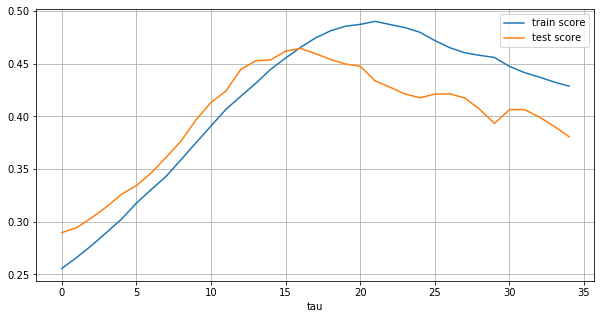

In [8]:
score_by_tau = pd.DataFrame({'tau':range(0,TAU_RANGE),'train score':train_score,'test score':test_score})
score_by_tau.set_index('tau').plot(figsize=(10,5), grid=True)

In [ ]:
train_score

In [ ]:
test_score

In [ ]:
coefficients = dict(zip(eu_response["Response_measure"].unique(), linear_regressor.coef_))
plt.figure(figsize=(6,12))
plt.barh(y = list(coefficients.keys()), width = coefficients.values())
plt.title("Coefficients $\\beta$ for each response_measure")

## Keras Sequential Model

Using df with more cols from owid

In [135]:
from keras.layers import Dense, Activation
from keras.models import Sequential

In [136]:
from sklearn.metrics import mean_squared_error
# RMSE metric
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

In [182]:
# create X and y for train and test
x_cols = ['population',    # cols from owid in df except reproduction_rate (y variable), location, and date
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand','life_expectancy', 'human_development_index',
       't', 't2', 't3', 't4', 't5'
       ] + list(eu_response["Response_measure"].unique())# + list(eu_response["Country"].unique())
y_cols = ["reproduction_rate"]

X_train = train[x_cols]
y_train = train[y_cols]

X_test = test[x_cols]
y_test = test[y_cols]



# df = df.dropna()
# X_train = df.drop(["reproduction_rate"], axis=1)
# y_train = df["reproduction_rate"]

X_train.shape

(4752, 83)

In [183]:
# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(16, activation = 'relu', input_dim = X_train.shape[1]))

# Adding the second hidden layer
model.add(Dense(units = 16, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 16, activation = 'relu'))

# Adding the output layer

model.add(Dense(units = 1))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [185]:
%%time
history = model.fit(X_train, y_train, batch_size = 32, epochs = 400, validation_split=0.2)

Epoch 1/400
149/149 [==============================] - 0s 1ms/step - loss: nan
Epoch 2/400
149/149 [==============================] - 0s 1ms/step - loss: nan
Epoch 3/400
149/149 [==============================] - 0s 1ms/step - loss: nan
Epoch 4/400
149/149 [==============================] - 0s 1ms/step - loss: nan
Epoch 5/400
149/149 [==============================] - 0s 1ms/step - loss: nan
Epoch 6/400
149/149 [==============================] - 0s 1ms/step - loss: nan
Epoch 7/400
149/149 [==============================] - 0s 2ms/step - loss: nan
Epoch 8/400
149/149 [==============================] - 0s 2ms/step - loss: nan
Epoch 9/400
149/149 [==============================] - 0s 1ms/step - loss: nan
Epoch 10/400
149/149 [==============================] - 0s 1ms/step - loss: nan
Epoch 11/400
149/149 [==============================] - 0s 1ms/step - loss: nan
Epoch 12/400
149/149 [==============================] - 0s 2ms/step - loss: nan
Epoch 13/400
149/149 [===========================

KeyboardInterrupt: 

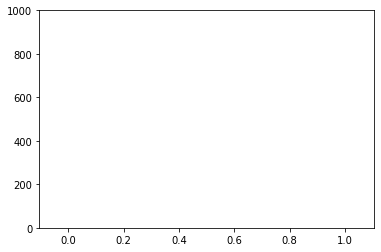

In [148]:
axes = plt.gca()
axes.set_ylim([0,1000])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [95]:
print("RMSE: " + str(rmse(y_test, model.predict(X_test))))

RMSE: 0.3746277543777617
